This notebook queries .las file tiles using tile bounding boxes file, then clips the point cloud to building footprint extent. Running this notebook requires laspy python library which can be installed by _pip install laspy[lazrs]_

### Load dependencies

In [ ]:
import boto3
import laspy
import geopandas as gpd
from shapely.geometry import Point, Polygon
import subprocess
import json
import os
import numpy as np
from shapely.vectorized import contains
from laspy.header import LasHeader
from laspy import PointFormat
import matplotlib.pyplot as plt

### Set input files

In [7]:
building_footprint_path = r"C:/Users/lliu/Desktop/FrontierSI/projects/GA_floor_height/QA4lidar/test_footprint.shp"
tile_bbox_path=r'C:/Users/lliu/Desktop/FrontierSI/projects/GA_floor_height/QA4lidar/tile_bbox.geojson'

### Connect to AWS buket

In [3]:
mfa_token = '148615' # replace with latest token
cmd = (f'C:\\Program Files\\Amazon\\AWSCLIV2\\aws sts get-session-token --serial-number arn:aws:iam::693903849513:mfa/Lavender_AWS_MFA  --token-code {mfa_token}').split()
result = subprocess.run(cmd, capture_output=True)
bucket_name = 'frontiersi-p127-floor-height-private'

# Check if the command was successful
if result.returncode == 0:
    # Parse JSON output into a dictionary
    data = json.loads(result.stdout)
    #print(data)  # Print or process the dictionary
else:
    print("Error:", result.stderr)

In [4]:
session = boto3.session.Session(
    aws_access_key_id=data['Credentials']['AccessKeyId'],
    aws_secret_access_key=data['Credentials']['SecretAccessKey'],
    aws_session_token=data['Credentials']['SessionToken']
)
# Initialize an S3 client
s3 = session.client('s3')

### Load bounding box tiles of las files

In [5]:
gdf_tile_bbox=gpd.read_file(tile_bbox_path)
gdf_tile_bbox.head()

,filename,point_count,min_z,max_z,crs,geometry
0,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,0,16.54,-4.22,EPSG:28355,"POLYGON ((724502.82 7662043.9, 724502.82 76620..."
1,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,0,29.51,2.26,EPSG:28355,"POLYGON ((724550 7662049.99, 724550 7662000, 7..."
2,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,0,17.49,-15.61,EPSG:28355,"POLYGON ((724556.56 7662099.96, 724556.56 7662..."
3,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,0,44.31,-26.80,EPSG:28355,"POLYGON ((724600 7662049.99, 724600 7662000, 7..."
4,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,0,34.11,-1.68,EPSG:28355,"POLYGON ((724600 7662099.99, 724600 7662050, 7..."


### Load building footprints

In [8]:
gdf_building_footprint=gpd.read_file(building_footprint_path)
# Ensure CRS matches
if gdf_building_footprint.crs != gdf_tile_bbox.crs:
    gdf_building_footprint = gdf_building_footprint.to_crs(gdf_tile_bbox.crs)
gdf_building_footprint

,id,geometry
0,0,"POLYGON ((725085.508 7662233.349, 725104.564 7..."
1,1,"POLYGON ((725359.728 7662171.352, 725362.945 7..."
2,2,"POLYGON ((725658.697 7662144.499, 725671.443 7..."
3,3,"POLYGON ((727576.961 7662517.345, 727579.601 7..."


### Read in a single building outline to test workflow

In [47]:
building_polygon = gdf_building_footprint.geometry.iloc[2]
building_id=gdf_building_footprint.iloc[2]['id']
building_id

2

### Buffer building footprint

In [48]:
buffer_distance = 2  # Adjust buffer distance based on CRS (e.g., meters or degrees)
building_polygon = building_polygon.buffer(buffer_distance)

### Find overlapping tile(s)

In [49]:
# Find overlapping tiles
overlapping_tiles = gdf_tile_bbox[gdf_tile_bbox.geometry.intersects(building_polygon)]
overlapping_tiles

,filename,point_count,min_z,max_z,crs,geometry
172,lidar/qa4mobile/531_MCPPC_F2_201402_MGA94_55_7...,4135714816,12.59,3.15,EPSG:28355,"POLYGON ((725650 7662149.99, 725650 7662100, 7..."


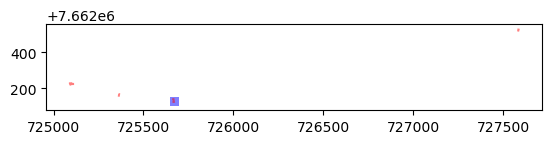

In [ ]:
overlapping_tiles.plot(color="blue", alpha=0.5)
gdf_building_footprint.plot(color="red", alpha=0.5, ax=plt.gca())
plt.show()

### Download all overlapping tiles, merge, clip and save to file

In [ ]:
merged_points = []
output_directory=os.path.dirname(tile_bbox_path)
# Download and process each overlapping tile
for _, tile in overlapping_tiles.iterrows():
    las_file_key=tile["filename"]
    tile_name = os.path.basename(las_file_key)
    local_las_path = os.path.join(output_directory, tile_name)
    
    # Download LAS file from S3
    s3.download_file(bucket_name, las_file_key, local_las_path)
    
    # Load LAS file
    las = laspy.read(local_las_path)
    points = las.xyz  # Extract points (X, Y, Z)
    merged_points.append(points)

# Merge all points into a single array
merged_points = np.vstack(merged_points)

# Filter points inside the building footprint
las_points = [Point(x, y) for x, y, z in merged_points]
inside_mask = contains(building_polygon, merged_points[:, 0], merged_points[:, 1])
clipped_points = merged_points[inside_mask]
print(f"Filtered points shape: {clipped_points.shape}")

# Create a new header with the same point format as the original
new_header = LasHeader(point_format=las.header.point_format, version=las.header.version)
# Initialize a new LAS file with the new header
clipped_las = laspy.LasData(new_header)
clipped_las.x = clipped_points[:, 0]
clipped_las.y = clipped_points[:, 1]
clipped_las.z = clipped_points[:, 2]

# Save the clipped LAS file locally
clipped_las_path = os.path.join(output_directory, str(building_id)+'_clipped_buffered.las')
clipped_las.write(clipped_las_path)

Filtered points shape: (9949, 3)
